In [1]:
import gauss_decomp as gdc
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from iris_lmsalpy import extract_irisL2data as ei
from scipy.io import readsav
from iris_lmsalpy import saveall as sv
import glob
import matplotlib

In [2]:
os.environ['path']= '/Users/souvikb/various_analysis/GaussSep/'
os.environ['results_dir'] = '/Users/souvikb/various_analysis/GaussSep/Results/'
os.environ['saved_files'] = '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/'

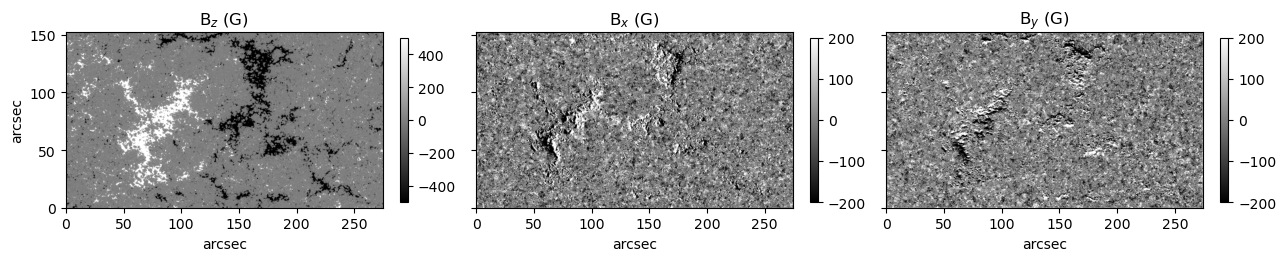

In [15]:
## Reading the Hinode SOT/SP Magnetic field maps
b_mag = readsav(os.path.join(os.environ['path'],'bose_codes/SOT_B_data/bxbybz_29Jul2017_plage.sav'))
b_mag.keys()
Bx0_obs = b_mag['bx2']
By0_obs = b_mag['by2']
Bz0_obs = b_mag['bz2']
# Bz0_obs.shape
fig, ax = plt.subplots(nrows=1, ncols =3,figsize=(15,5),sharex=True,sharey=True)
ax= ax.ravel()

im=ax[0].imshow(Bz0_obs, cmap='gray', vmax=500,vmin=-500,origin='lower', extent =[0,Bz0_obs.shape[1]*y_sampling_sot, 0,Bz0_obs.shape[0]*x_sampling_sot])
ax[0].set_title(r'B$_{z}$ (G)')
ax[0].set_xlabel('arcsec')
ax[0].set_ylabel('arcsec')
plt.colorbar(im, fraction=0.024)

im=ax[1].imshow(Bx0_obs, cmap='gray', vmax=200,vmin=-200,origin='lower',extent =[0,Bz0_obs.shape[1]*y_sampling_sot, 0,Bz0_obs.shape[0]*x_sampling_sot])
ax[1].set_title(r'B$_{x}$ (G)')
ax[1].set_xlabel('arcsec')
plt.colorbar(im, fraction=0.024)

im=ax[2].imshow(By0_obs, cmap='gray', vmax=200,vmin=-200,origin='lower',extent =[0,Bz0_obs.shape[1]*y_sampling_sot, 0,Bz0_obs.shape[0]*x_sampling_sot])
ax[2].set_title(r'B$_{y}$ (G)')
ax[2].set_xlabel('arcsec')
plt.colorbar(im, fraction=0.024)
# plt.savefig(os.path.join(os.environ['results_dir'],'BxByBz_SOT_input.png'), dpi=300, bbox_inches='tight')

## Performing the Poloidal-Toroidal decomposition

In [5]:
#------------------------------
# Do PTD, to get toroidal component of horizontal field 
Btx_obs,Bty_obs,Bpx_obs,Bpy_obs,T_obs,dPdz_obs,P_obs,bx_mean_obs,by_mean_obs,bz_mean_obs = \
gdc.ptd_fft_2d( Bx0_obs, By0_obs, Bz0_obs)

In [16]:
#------------------------------
# Do Gauss Sep
Bltx_obs, Blty_obs, Bltz_obs, psilt_obs, \
Bgtx_obs, Bgty_obs, Bgtz_obs, psigt_obs, \
Bx_mean_obs, By_mean_obs, Bz_mean_obs = \
gdc.gauss_sep( Bx0_obs, By0_obs, Bz0_obs)

Text(0.5, 1.0, '$\\vec{B}^{>}(x, y, 0)$ due to $\\vec{J}^{>}$')

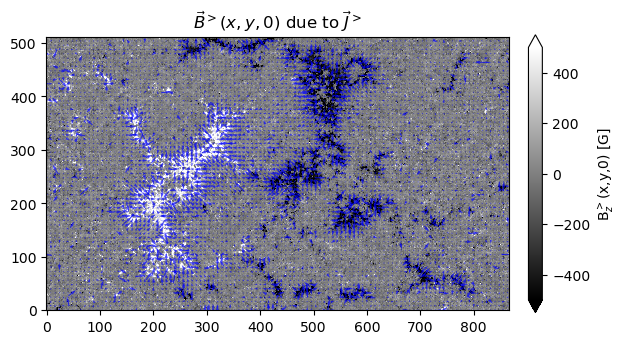

In [17]:
ny, nx = Bgtx_obs.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
plt.imshow(Bgtz_obs, origin='lower', cmap='gray',interpolation='none',vmax=500,vmin=-500)
# plt.contour(Bz0_obs, levels=[1], colors='black')
plt.colorbar(label='B$^{>}_{z}$(x,y,0) [G]', fraction=0.028, pad=0.04,extend='both')
plt.quiver(
    x[::8, ::8], y[::8, ::8],
    Bgtx_obs[::8, ::8], Bgty_obs[::8, ::8],
    scale=2e4, color='blue', pivot='mid',alpha=0.7
)
plt.title(r'$\vec{B}^{>}(x, y, 0)$ due to $\vec{J}^{>}$')

Text(0.5, 1.0, 'Magnetic Energy Density due to J$^{>}$')

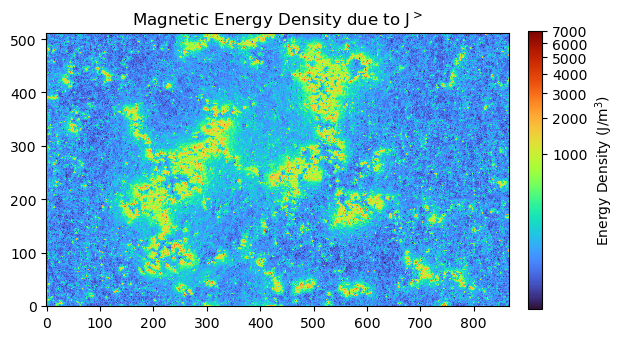

In [18]:
## Calculating the magnetic energy density >0
Bgtx_SI = Bgtx_obs * 1e-4  # Convert to Tesla
Bgty_SI = Bgty_obs * 1e-4
Bgtz_SI = Bgtz_obs * 1e-4
mu_0 = 1.257e-6 # Permeability of free space in T*m/A
B_energy_density = 0.5 * (Bgtx_SI**2 + Bgty_SI**2 + Bgtz_SI**2) / mu_0
plt.imshow(B_energy_density, origin='lower', cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=7e3))
plt.colorbar(label='Energy Density (J/m$^3$)', fraction=0.028, pad=0.04)
plt.title('Magnetic Energy Density due to J$^{>}$')
# plt.savefig(os.path.join(os.environ['results_dir'], 'B_energy_density.png'), dpi=300, bbox_inches='tight')

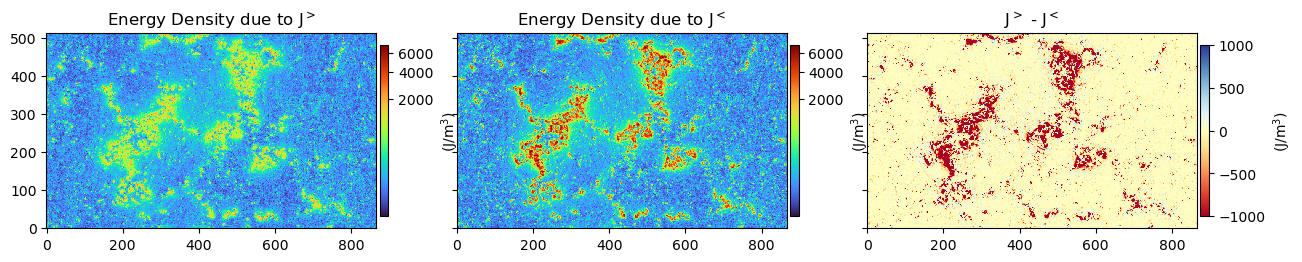

In [19]:
## Calculating the magnetic energy density <, > and difference between > and <
Bltx_SI = Bltx_obs * 1e-4  # Convert to Tesla
Blty_SI = Blty_obs * 1e-4
Bltz_SI = Bltz_obs * 1e-4
mu_0 = 1.257e-6 # Permeability of free space in T*m/A
B_energy_density_lt = 0.5 * (Bltx_SI**2 + Blty_SI**2 + Bltz_SI**2) / mu_0
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15,5))
ax =ax.ravel()

im = ax[0].imshow(B_energy_density, origin='lower', cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=7e3))
plt.colorbar(im,fraction=0.025,pad=0.01, label='(J/m$^3$)')
ax[0].set_title('Energy Density due to J$^{>}$')

im = ax[1].imshow(B_energy_density_lt, origin='lower', cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=7e3))
plt.colorbar(im,fraction=0.025,pad=0.01, label='(J/m$^3$)')
ax[1].set_title('Energy Density due to J$^{<}$')

im = ax[2].imshow(B_energy_density - B_energy_density_lt, cmap='RdYlBu',interpolation='none', vmax=1000,vmin=-1000, origin='lower')
plt.colorbar(im,fraction=0.025,pad=0.01, label='(J/m$^3$)')
ax[2].set_title(r'J$^{>}$ - J$^{<}$')
plt.savefig(os.path.join(os.environ['results_dir'], 'energy_density_gt_lt_z=0.png'), dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'where (J$^{>}$ - J$^{<}$) > 0')

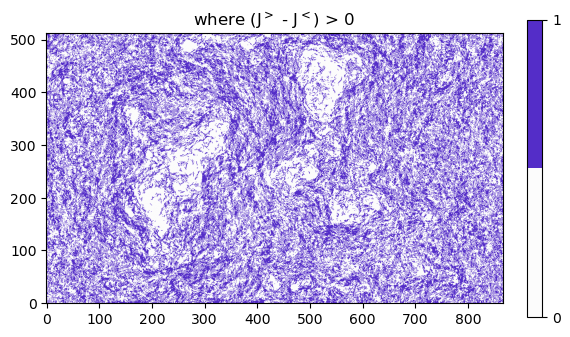

In [121]:
colors1 = ["#FCFCFC", "#542dc8"]
cmap = matplotlib.colors.ListedColormap(colors1)
plt.imshow(np.where(B_energy_density - B_energy_density_lt > 0, 1.0, 0), cmap=cmap, origin='lower',vmin=0, vmax=1)
cbar = plt.colorbar(ticks=range(2), fraction=0.03)
cbar.ax.set_yticklabels(["0", "1"])
plt.title(r'where (J$^{>}$ - J$^{<}$) > 0')

### Using log energy density as per Brian's suggestions

Text(0.5, 0, 'arcsec')

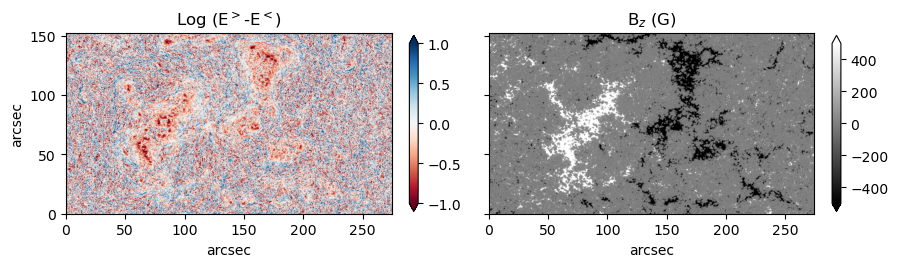

In [53]:
log_difference = np.log10(B_energy_density) - np.log10(B_energy_density_lt)
fig, ax = plt.subplots(nrows=1,ncols =2, sharex=True, sharey=True, figsize=(10,5))
ax = ax.ravel()
im = ax[0].imshow(log_difference, origin = 'lower', cmap ='RdBu',vmax=1., vmin=-1., extent =[0,Bz0_obs.shape[1]*y_sampling_sot, 0,Bz0_obs.shape[0]*x_sampling_sot])
ax[0].set_title(r'Log (E$^{>}$-E$^{<}$)')
ax[0].set_xlabel('arcsec')
ax[0].set_ylabel('arcsec')

plt.colorbar(im, fraction=0.025, extend='both')

im = ax[1].imshow(Bz0_obs, cmap='gray', vmax=500,vmin=-500,origin='lower', extent =[0,Bz0_obs.shape[1]*y_sampling_sot, 0,Bz0_obs.shape[0]*x_sampling_sot],
                  )
ax[1].set_title(r'B$_{z}$ (G)')
plt.colorbar(im, fraction=0.025, extend='both')
ax[1].set_xlabel('arcsec')

## Attempting to co-align begins here. There are a lot of files from the IDL session in parsec

In [5]:
## Reading alignment parameters from the IDL session
saved_files = glob.glob(os.path.join(os.environ['saved_files'],'*.sav'))
saved_files

['/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/time_sot_aligned_IRIS_cont.sav',
 '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/shifts_and_sot_broad_coverage.sav',
 '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/complete_sot_iris_xcen.sav',
 '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/start_end_slit_indices_sampling_info.sav',
 '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/original_IRIS_SOT_times.sav',
 '/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/time_iris_cont.sav']

In [6]:
for ii, files in enumerate(saved_files):
    print(files, readsav(files).keys())

/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/time_sot_aligned_IRIS_cont.sav dict_keys(['t_sot_aligned_iris_cont'])
/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/shifts_and_sot_broad_coverage.sav dict_keys(['sot_t_aligned_steps', 'shift'])
/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/complete_sot_iris_xcen.sav dict_keys(['crval_sot', 'crval_iris_rast'])
/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/start_end_slit_indices_sampling_info.sav dict_keys(['y_sampling_sot', 'x_sampling_sot', 'dypos_iris', 'dxpos_iris', 'sot_slit_start_stop', 'iris_slit_start_stop'])
/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/original_IRIS_SOT_times.sav dict_keys(['t_utc', 't_obs'])
/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/time_iris_cont.sav dict_keys(['t_iris_cont'])


Text(0.5, 1.0, 'IRIS & SOT X_CEN')

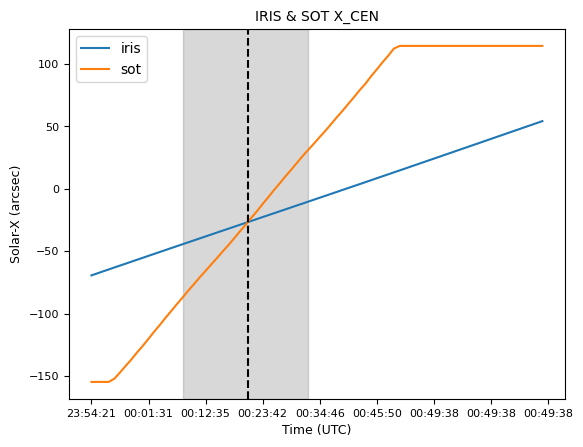

In [7]:
## Plotting overall IRIS and SOT slit pointing for the entire duration of the coordination
t_sot_aligned_iris_cont = readsav(saved_files[0])['t_sot_aligned_iris_cont']
iris_x_pointings = readsav(saved_files[2])['crval_iris_rast']
sot_x_pointingss = readsav(saved_files[2])['crval_sot']
plt.plot(iris_x_pointings, label = 'iris')
plt.plot(sot_x_pointingss, label='sot')
ticks = [0,10,20,30,40,50,60,70,80]
ticklabels = [t_sot_aligned_iris_cont[0].decode('utf-8')[11:19], t_sot_aligned_iris_cont[10].decode('utf-8')[11:19],t_sot_aligned_iris_cont[20].decode('utf-8')[11:19], 
              t_sot_aligned_iris_cont[30].decode('utf-8')[11:19], t_sot_aligned_iris_cont[40].decode('utf-8')[11:19], t_sot_aligned_iris_cont[50].decode('utf-8')[11:19],
              t_sot_aligned_iris_cont[60].decode('utf-8')[11:19], t_sot_aligned_iris_cont[70].decode('utf-8')[11:19], t_sot_aligned_iris_cont[79].decode('utf-8')[11:19]]
# plt.xticks([t_sot_aligned_iris_cont[0].decode('utf-8'), t_sot_aligned_iris_cont[10].decode('utf-8')])
# plt.axhline(y=0, ls='--', lw=0.5, color='black')
plt.xticks(ticks, ticklabels)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.axvline(x=27.5, color='black', ls ='--')
plt.axvspan(xmin=27-11, xmax=27+11,color='gray',alpha=0.3)
plt.legend()
plt.ylabel('Solar-X (arcsec)',fontsize=9)
plt.xlabel('Time (UTC)',fontsize=9)
plt.title('IRIS & SOT X_CEN',fontsize=10)

In [9]:
## Time indices aligned SOT
sot_slit_extent_final = readsav(saved_files[1])['sot_t_aligned_steps'] ## post time alignment crop to perform cross-correlation

## actual extent for T_aligned SOT map
sot_slit_start_stop = readsav(saved_files[3])['sot_slit_start_stop']

plt.imshow(B_energy_density[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1],origin='lower',
           cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=6.e3))
xtick_positions = [0, 100, 200, 300]
xtick_labels =['a', 'b', 'c', 'd']
plt.xticks(xtick_positions, xtick_labels, fontsize=10)
plt.colorbar(fraction=0.03)

size_sot_t_aligned = B_energy_density[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1].shape ## +1 to keep consistence between IDL and Python versions.
size_sot_t_aligned_E_lt = B_energy_density_lt[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1].shape
## There are 384 slits with ~3.2s cadence 

# print(size_sot_t_aligned)
### To plot the following plot where you want to replace the x-axis with t_obs from IDL and choose the indices sot_slit_start_stop[0]:sot_slit_start_stop[1]+1

NameError: name 'B_energy_density' is not defined

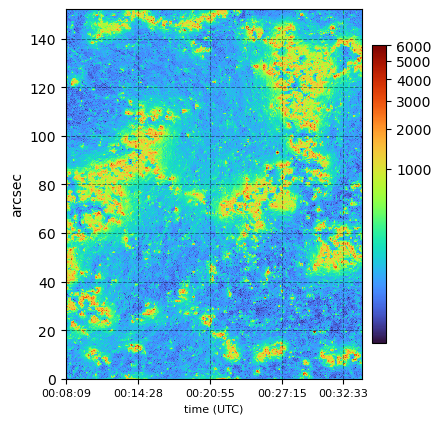

In [220]:
### reading the original SOT and IRIS times
orig_times = readsav('/Users/souvikb/various_analysis/GaussSep/bose_codes/alignment_saved_files/original_IRIS_SOT_times.sav')
t_iris = orig_times['t_utc']
t_sot = orig_times['t_obs']
shape_energy_density = B_energy_density[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1].shape
plt.imshow(B_energy_density[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1],origin='lower',
           cmap='turbo', interpolation='none',norm=colors.PowerNorm(0.3,vmax=6.e3),
           extent =[0,shape_energy_density[1]*y_sampling_sot, 0,shape_energy_density[0]*x_sampling_sot])
xtick_positions = [0*x_sampling_sot, 100*x_sampling_sot, 200*x_sampling_sot, 300*x_sampling_sot, 384*x_sampling_sot]
xtick_labels =[t_sot[sot_slit_start_stop[0]].decode('utf-8')[11:19], t_sot[sot_slit_start_stop[0]+100].decode('utf-8')[11:19],
               t_sot[sot_slit_start_stop[0]+200].decode('utf-8')[11:19], t_sot[sot_slit_start_stop[0]+300].decode('utf-8')[11:19],
               t_sot[sot_slit_start_stop[1]].decode('utf-8')[11:19]]
plt.xticks(xtick_positions, xtick_labels, fontsize=8)
plt.colorbar(fraction=0.03, pad=0.02)
plt.xlabel('time (UTC)', size=8)
plt.ylabel('arcsec')
plt.grid(True, color='black',linestyle='--', linewidth=0.7, alpha=0.4)
plt.savefig(os.path.join(os.environ['results_dir'], 'co_temporal_SOT_map.png'), dpi=300, bbox_inches='tight')
# t_sot

### Loading the IRIS2+ atmospheric params

In [10]:
aux = sv.load('/Users/souvikb/various_analysis/iris2_p/l2_iris_data/Photospheric_imprints_IRIS_l2_data/inv_mod_IRIS2p_knn_c3_iris_l2_20170729_234952_3620010077_raster_t000_r00000.jbl')
model = aux['model']
model[0]['wl'][10:14]
model[0]['wl'][14:18]
# for m in model: print(m.label_units)


Loading joblib file... /Users/souvikb/various_analysis/iris2_p/l2_iris_data/Photospheric_imprints_IRIS_l2_data/inv_mod_IRIS2p_knn_c3_iris_l2_20170729_234952_3620010077_raster_t000_r00000.jbl
The varible types are:
data : <class 'numpy.memmap'>
inv : <class 'numpy.memmap'>
model : <class 'list'>
wl : <class 'numpy.memmap'>
wlc : <class 'list'>
wl2size : <class 'list'>
wl2scl : <class 'list'>
extent : <class 'list'>
extent_coords : <class 'tuple'>
mu : <class 'numpy.float64'>
texp : <class 'float'>
obsid : <class 'str'>
percentages : <class 'dict'>
crop_wei4knn : <class 'list'>
chi2 : <class 'numpy.memmap'>
inv_method : <class 'str'>
original_filename : <class 'str'>
name_jbl : <class 'str'>
jbl_file_saving_stamptime : <class 'str'>


Suggested commands:
data = aux['data']
inv = aux['inv']
model = aux['model']
wl = aux['wl']
wlc = aux['wlc']
wl2size = aux['wl2size']
wl2scl = aux['wl2scl']
extent = aux['extent']
extent_coords = aux['extent_coords']
mu = aux['mu']
texp = aux['texp']
obsid 

memmap([-4.8, -4.6, -4.4, -4.2])

In [11]:
## Extracting the IRL, temperature and Electron densities from IRIS2+ in the relevant optical depths
IRL = model[4].data[:,:,1] ## Integrated radiative losses
Temp = np.nanmean(model[0].data[:,:,10:14],axis=2) ## Temperature averaged between log tau = [-5.6, -5.4, -5.2, -5. ]
# Temp = np.nanmean(model[0].data[:,:,14:18],axis=2) ## Temperature averaged between log tau = [-4.8, -4.6, -4.4, -4.2]
Ne = np.nanmean(model[3].data[:,:,10:14],axis=2) ## Electron density averaged between ---""------
# Ne = np.nanmean(model[3].data[:,:,14:18],axis=2) ## Electron density averaged between ---""------log tau = [-4.8, -4.6, -4.4, -4.2]

In [12]:
## actual extent for time_aligned IRIS raster map
iris_slit_start_stop = readsav(saved_files[3])['iris_slit_start_stop']

## The below is the time aligned slits for the duration between 27-11 to 27+11. There are 89 slits with a cadence of ~15 seconds
IRL_t_aligned = IRL[:,iris_slit_start_stop[0]:iris_slit_start_stop[-1]+1]
Temp_t_aligned = Temp[:,iris_slit_start_stop[0]:iris_slit_start_stop[-1]+1]
Ne_t_aligned = Ne[:,iris_slit_start_stop[0]:iris_slit_start_stop[-1]+1]
size_iris_t_aligned = IRL_t_aligned.shape
print(size_iris_t_aligned)

(1095, 89)


/var/folders/ms/lnhrcvqs3z1c4t2zkhv2wt600000gp/T/ipykernel_12558/3080707207.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax[2].imshow(np.log10(Ne_t_aligned),interpolation='nearest',vmin=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 10.5)),vmax=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 99)),


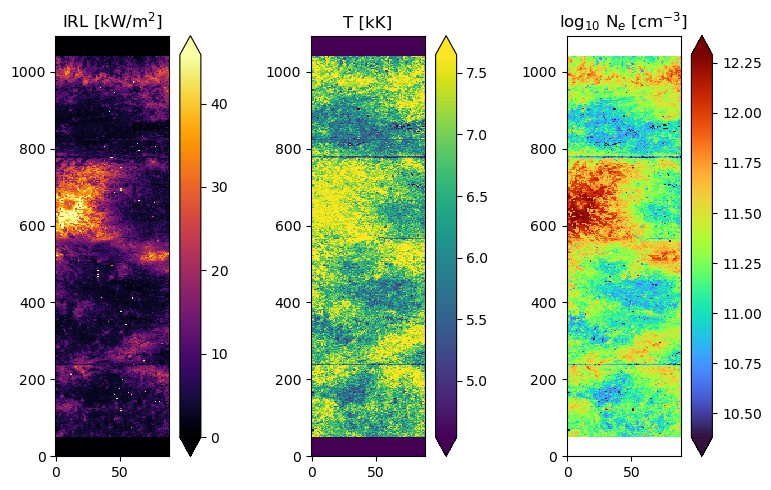

In [13]:
fig, ax = plt.subplots(1,3, figsize=(8,5))
im=ax[0].imshow(IRL_t_aligned,interpolation='nearest',vmin=np.nanpercentile(model[4].data[:,:,1], 1),vmax=np.nanpercentile(model[4].data[:,:,1], 99),
        origin='lower',cmap='inferno',aspect=0.3)
# ax[0].set_title('Bz [G]')
# ax[0].set_xlabel('X [arcsec]')
# ax[0].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[0], orientation='vertical',extend='both')
ax[0].set_title('IRL [kW/m$^{2}$]')

im = ax[1].imshow(Temp_t_aligned,interpolation='nearest',vmin=np.nanpercentile(model[0].data[:,:,10:14], 10),vmax=np.nanpercentile(model[0].data[:,:,10:14], 75),
        origin='lower',cmap='viridis',aspect=0.3)
# ax[1].set_title('Bz [G]')
# ax[1].set_xlabel('X [arcsec]')
# ax[1].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[1], orientation='vertical', extend='both')
ax[1].set_title('T [kK]')

im = ax[2].imshow(np.log10(Ne_t_aligned),interpolation='nearest',vmin=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 10.5)),vmax=np.log10(np.nanpercentile(model[3].data[:,:,10:14], 99)),
        origin='lower',cmap='turbo',aspect=0.3)
# ax[2].set_title('Bz [G]')
# ax[2].set_xlabel('X [arcsec]')
# ax[2].set_ylabel('Y [arcsec]')
fig.colorbar(im, ax=ax[2], orientation='vertical', extend='both')
ax[2].set_title('log$_{10}$ N$_e$ [cm$^{-3}$]')
fig.tight_layout()

### Re-sample time aligned (1095,89) sized IRIS arrays to SOT pixel scale which can be retrieved from start_end_slit_indices_sampling_info.sav


In [14]:
## from IDL :
y_sampling_sot = readsav(saved_files[3])['y_sampling_sot']
x_sampling_sot = readsav(saved_files[3])['x_sampling_sot']
dypos_iris = readsav(saved_files[3])['dypos_iris']
dxpos_iris = readsav(saved_files[3])['dxpos_iris']
# I will try to implement the Python equivalent of the following:
# ---> iris_exp = congrid(iris_t_aligned, round(size_iris_t[1]*dxpos_iris/x_sampling_sot[0]),round(size_iris_t[2]*dypos_iris/y_sampling_sot[0]),cubic=-0.5) 
# ----- be sure to check if the x is actually the x because IDL --> Python x (in IDL is columns) become y (in Python y in the columns) and vice-versa.

from scipy.ndimage import zoom ## Zoom from scipy does all and more than congrid in IDL
nx, ny = IRL_t_aligned.shape  # current (rows, cols) in arcsec map
# print(nx,ny)
scale_x = (np.shape(IRL_t_aligned)[0] * dypos_iris / y_sampling_sot) / nx
scale_y = (np.shape(IRL_t_aligned)[1] * dxpos_iris / x_sampling_sot) / ny
# print(scale_x,scale_y)

IRIS2_t_aligned_params = [IRL_t_aligned,Temp_t_aligned,Ne_t_aligned]
IRIS2_resampled = []

for params in IRIS2_t_aligned_params:
    # print(params)

    resampled= zoom(params,
                    zoom=(scale_x, scale_y),
                    order=3, #order = 3 Cubic spline interpolation
                    mode='nearest') # for edges
    IRIS2_resampled.append(resampled)

print(IRIS2_resampled[0].shape)## Exactly the size I wanted.

(574, 116)


#### The resampled IRIS2+ params are now in SOT pixel scale

Now that IRIS is resampled to SOT pixel scale, we still need to crop the SOT raster map's FOV. This is because the SOT `x_cen` pointing changes from `-86" to 31"` during the above time interval, while the IRIS `rast xpos` pointing changes from `-44" to -10"` during the above time interval.

Keeping resampled IRIS FOVs as the master, we crop SOT FOV to best match the IRIS FOV in space and time

  

(512, 135) (512, 135)


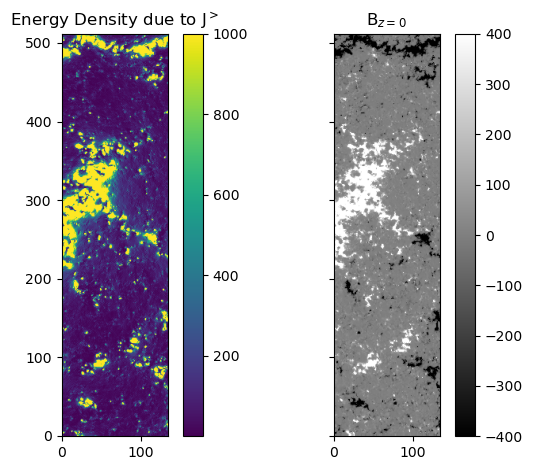

In [132]:
## We need the information
## Time indices aligned SOT
sot_slit_extent_final = readsav(saved_files[1])['sot_t_aligned_steps'] ## post time alignment crop to perform the CROP and later the cross-correlation (this is done in IDL and we have the shifts)

B_energy_density_t_aligned = B_energy_density[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1] ## time aligned map
B_energy_density_t_aligned_lt = B_energy_density_lt[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1]

Bz0_obs_t_aligned = Bz0_obs[:,sot_slit_start_stop[0]:sot_slit_start_stop[1]+1] ## time aligned B_los map

B_energy_density_gt_cropped = B_energy_density_t_aligned[:,sot_slit_extent_final[0]:sot_slit_extent_final[1]]
B_energy_density_lt_cropped = B_energy_density_t_aligned_lt[:,sot_slit_extent_final[0]:sot_slit_extent_final[1]]
Bz0_obs_cropped = Bz0_obs_t_aligned[:,sot_slit_extent_final[0]:sot_slit_extent_final[1]]

fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)
ax.ravel()
im = ax[0].imshow(B_energy_density_lt_cropped,origin='lower',vmax=1000)
plt.colorbar(im)
ax[0].set_title('Energy Density due to J$^{>}$')

im=ax[1].imshow(Bz0_obs_cropped, origin='lower', vmin=-400,vmax=400, cmap='gray')
plt.colorbar(im)
ax[1].set_title(r'B$_{z=0}$')

fig.tight_layout()
print(B_energy_density_gt_cropped.shape, Bz0_obs_cropped.shape)

In [133]:
## Although the above crop is roughly the same FOV as IRIS resampled parameters, there are some difference which need to compensated through cross-correlation. 
## This cross-correlation is done in IDL and I directly have the shifts (in x and y pixels) which I can straightaway use and compensate using Affine transform

## Compensating the x_shifts and y_shifts to match exactly with IRIS2+
shift = readsav(saved_files[1])['shift']
shift ## remember that rows and columns are interchanged and interpreted differently in IDL vs. Python.
from skimage.transform import AffineTransform, warp
transform = AffineTransform(translation=(shift[1], shift[0])) # x first, then y
aligned_B_energy_density_gt = warp(B_energy_density_gt_cropped, inverse_map=transform.inverse, preserve_range=True)
aligned_B_energy_density_lt = warp(B_energy_density_lt_cropped, inverse_map=transform.inverse, preserve_range=True)
aligned_B_zobs= warp(Bz0_obs_cropped.astype(float), inverse_map=transform.inverse, preserve_range=True)
print(aligned_B_energy_density_lt.shape, aligned_B_zobs.shape)


(512, 135) (512, 135)


(512, 116) (512, 116) (512, 116)


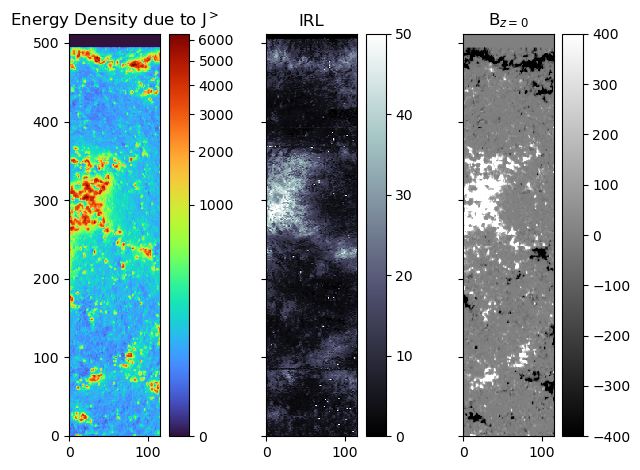

In [134]:
fig, ax = plt.subplots(ncols =3, nrows=1, sharex=True, sharey=True)
ax.ravel()
im = ax[0].imshow(aligned_B_energy_density_lt[:,:116],origin='lower', interpolation='nearest',cmap='turbo',norm=colors.PowerNorm(0.3))
plt.colorbar(im)
ax[0].set_title('Energy Density due to J$^{>}$')

im=ax[1].imshow(IRIS2_resampled[0][40:40+512,:],origin='lower', cmap='bone',vmin=0,vmax=50, interpolation='none')
plt.colorbar(im)
ax[1].set_title(r'IRL')

im=ax[2].imshow(aligned_B_zobs[:,:116], origin='lower', vmin=-400,vmax=400, cmap='gray',interpolation='none')
plt.colorbar(im)
ax[2].set_title(r'B$_{z=0}$')
fig.tight_layout()

print(aligned_B_energy_density_lt[:,:116].shape, IRIS2_resampled[0][40:40+512,:].shape, aligned_B_zobs[:,:116].shape)


In [235]:
 iris_slit_start_stop[0],iris_slit_start_stop[-1]+1, IRL_t_aligned.shape

(66, 155, (1095, 89))

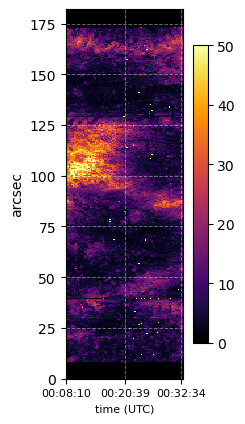

In [243]:
# IRL_plot_sot_align = IRIS2_resampled[0][40:40+512,:]
shape_IRL = IRL_t_aligned.shape
plt.imshow(IRL_t_aligned,cmap='inferno',vmin=0,vmax=50,origin='lower', interpolation='none',
           aspect=0.6, extent =[0,shape_IRL[1]*dxpos_iris, 0,shape_IRL[0]*dypos_iris])
xtick_positions = [0*dxpos_iris, 45*dxpos_iris, 88*dxpos_iris]
xtick_labels =[t_iris[iris_slit_start_stop[0]].decode('utf-8')[11:19], t_iris[iris_slit_start_stop[0]+45].decode('utf-8')[11:19],
               t_iris[iris_slit_start_stop[0]+88].decode('utf-8')[11:19]]
plt.xticks(xtick_positions, xtick_labels, fontsize=8)
plt.colorbar(fraction=0.03, pad=0.02)
plt.xlabel('time (UTC)', size=8)
plt.ylabel('arcsec')
plt.grid(True, color='white',linestyle='--', linewidth=0.7, alpha=0.4)
plt.savefig(os.path.join(os.environ['results_dir'], 'IRIS_raster_time_aligned.png'), dpi=300, bbox_inches='tight')

### Saving the cropped/aligned IRIS and SOT arrays for future comparison

In [135]:
np.savez(os.path.join(os.environ['results_dir'],'aligned_iris_sot_upper_chromos.npz'), E_density_gt =aligned_B_energy_density_gt[:,:116], E_density_lt =aligned_B_energy_density_lt[:,:116],
         IRL_IRIS2 = IRIS2_resampled[0][40:40+512,:], Ne_IRIS2 =IRIS2_resampled[2][40:40+512,:],
         Temp_IRIS2= IRIS2_resampled[1][40:40+512,:], B_z_cropped = aligned_B_zobs[:,:116])